## ABOUT
__Author__: Pat McCornack

__Date__: 2/28/24

__Purpose__: Investigate class distributions for the F40 model development effort. Includes:
- Sample distribution of F40.
- Sample distribution of EVT_Class.
- Sample dstributions of F40 and F40_GROUP within each EVT_CLASS.
- F40 sample vs. F40 layer distribution.
- F40 misclass distribution by model type.

__Questions__: This analysis is meant to address:
1. How imbalanced is the F40 dataset?
2. Are the F40 classes in agreeance with the EVT data? This is meant as a quick quality evaluation of the LF FBFM40 data. EVT_CLASS is the hierarchy that is closest to the FBFM40 "parent classes" (e.g. GR = Grass-Shrub) and this comparison should allow us to assess some of the noise in the FBFM40 data. 
3. Does the sample data distribution reflect the source data distribution?
4. How is the model performing? Are there patterns in where misclassifications are occurring?
5. How does the inclusion of F40_GROUP affect misclass distribution patterns?

----

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [2]:
sample_data_path = r"C:\Users\mcco573\OneDrive - PNNL\Documents\_Projects\BPA Wildfire\F40 Random Forest Model\data\F40_sample_points_100k_2-26-24_processed.csv"
sample_data = pd.read_csv(sample_data_path)
sample_data.head()

,Unnamed: 0,F40,FDST,FVC,FVH,ZONE,PYROME,ECOREGION,FVT,BPS_GROUPVEG,...,EVT_SBLCS,FDST_RECLASS,FVC_TREE,FVC_SHRUB,FVC_HERB,FVC_OTHER,FVH_TREE,FVH_SHRUB,FVH_HERB,FVH_OTHER
0,0,102,113,124,425,NaN,31.0,24.0,2270,7,...,Mixed evergreen-deciduous shrubland,1,0,0,124,0,0,0,425,0
1,2,102,0,125,425,NaN,32.0,27.0,2967,6,...,Annual Graminoid/Forb,0,0,0,125,0,0,0,425,0
2,3,165,0,105,623,NaN,32.0,27.0,2027,8,...,Evergreen open tree canopy,0,105,0,0,0,623,0,0,0
3,4,102,0,126,425,NaN,32.0,27.0,2967,6,...,Annual Graminoid/Forb,0,0,0,126,0,0,0,425,0
4,5,182,132,106,627,NaN,32.0,27.0,2030,7,...,Evergreen open tree canopy,1,106,0,0,0,627,0,0,0


## F40 Sample Densities
-----


In [3]:
F40_counts = sample_data.groupby('F40').count()[['FDST']]
F40_counts = F40_counts.reset_index().rename(columns={'FDST':'Count'})
F40_counts['Percent'] = F40_counts['Count'] / F40_counts['Count'].sum() * 100
F40_counts.head()

,F40,Count,Percent
0,101,2032,2.603593
1,102,12492,16.005945
2,103,122,0.156318
3,104,10,0.012813
4,106,10,0.012813


In [4]:
F40_counts.sort_values(by="Count", ascending=False).head()

,F40,Count,Percent
6,122,17652,22.617431
1,102,12492,16.005945
19,165,9025,11.563693
9,142,5929,7.596802
17,162,4501,5.767112


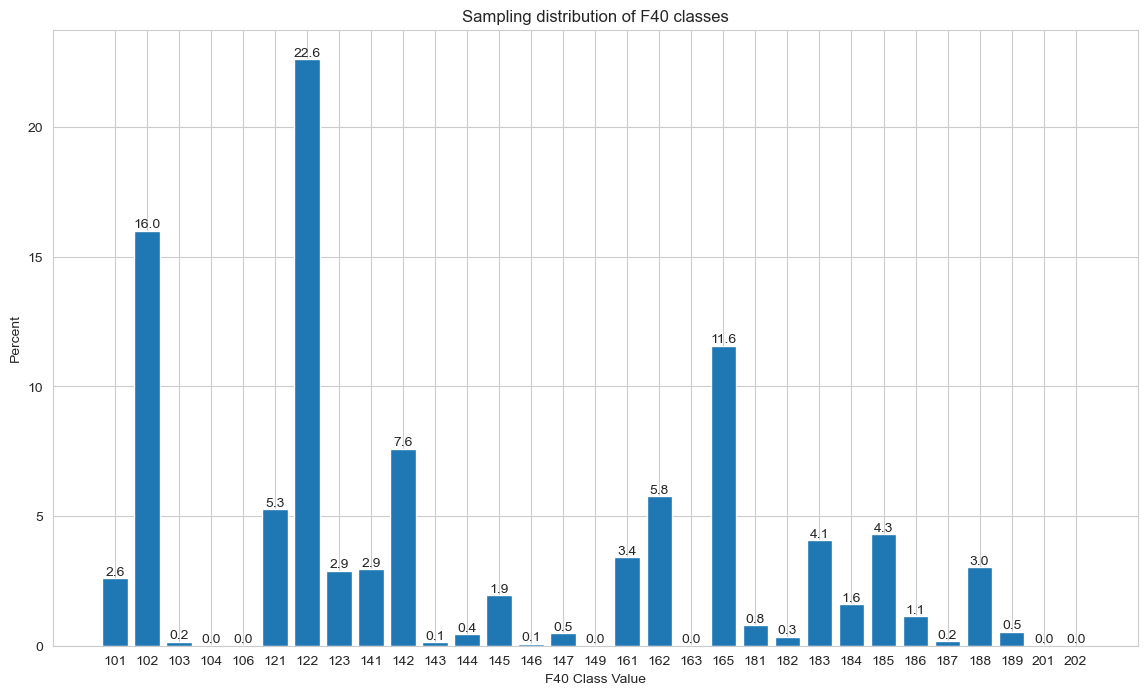

In [5]:
# Plot F40 counts in lexicographic order of F40 values
F40_counts['F40'] = F40_counts['F40'].astype('str')
metric = 'Percent'  # Percent; Count


f40_fig, f40_ax = plt.subplots(1, 1, figsize=(14,8))
bars = f40_ax.bar(F40_counts['F40'],
       F40_counts[metric])
f40_ax.set(title = "Sampling distribution of F40 classes",
       xlabel = "F40 Class Value",
       ylabel = metric)
f40_ax.bar_label(bars, fmt='%.1f')  # Add value labels to bars
plt.show()


## F40 Distributions within EVT_CLASS
EVT_CLASS can be thought of as analagous to the level of grouping done in F40 (e.g. GR, GS, SH). We want to look at the F40 distribution within several of these classes to see see how well the F40 classes map to them - this should give an idea of the level of noise in there. 

__FBFM Mappings__:
- 91-99: NB - Nonburnable
- 101-109: GR - Grass
- 121-124: GS - Grass-Shrub
- 141-149: SH - Shrub
- 161-165: TU - Timber-Understory
- 181-189: TL - Timber Litter
- 201-204: SB - Slash-Blowdown

__Summary__: 
- Overall the EVT_CLASS categories seem to agree with the F40 group pretty well.
- There's high class imbalance in some of the EVT_CLASS categories (see "Herbaceous - grassland")
-----

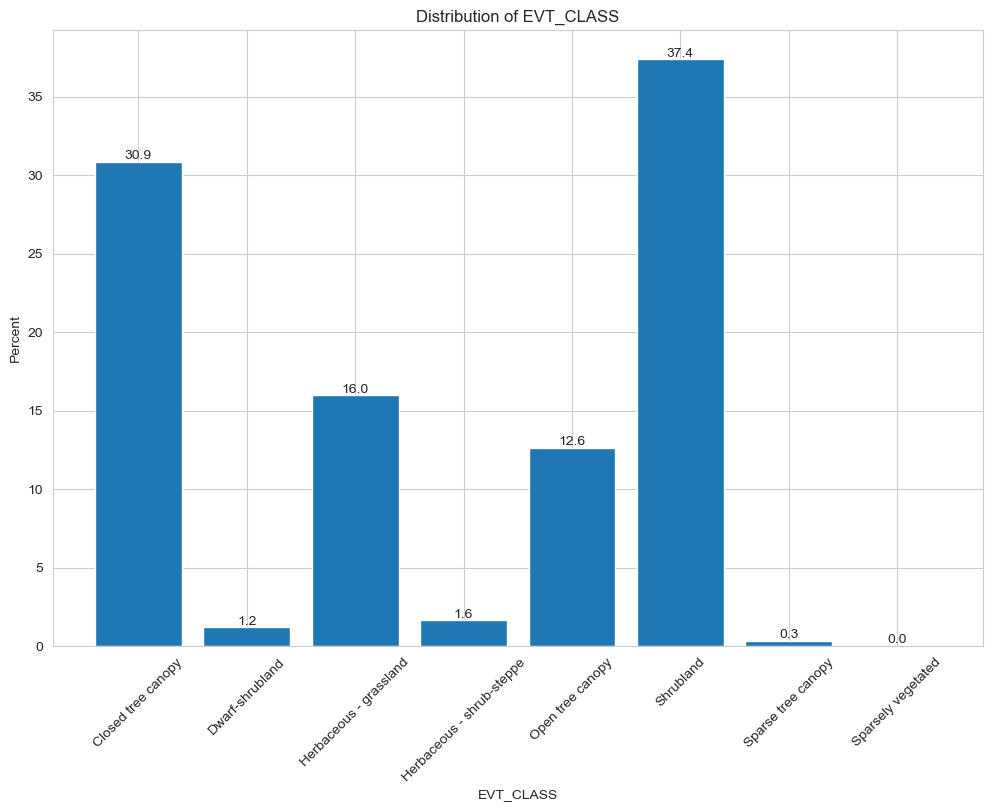

In [6]:
# First look at distribution of EVT_CLASS
df = sample_data.groupby('EVT_CLASS').count()[['F40']].reset_index()
df = df.rename(columns={'F40':'Count'})

df['Percent'] = df['Count'] / df['Count'].sum() * 100

fig, ax = plt.subplots(figsize=(12,8))
bars = ax.bar(df['EVT_CLASS'],
       df['Percent'])
ax.set(title="Distribution of EVT_CLASS",
       xlabel="EVT_CLASS",
       ylabel="Percent")
ax.bar_label(bars, fmt='%.1f')  # Add value labels to bars
plt.setp(ax.get_xticklabels(), rotation = 45)
plt.show()


In [7]:
# Create dictionary to aggregate F40 models into groups
F40_groups = {
    range(91, 100):'NonBurnable',
    range(101,110):'Grass',
    range(121,125):'Grass-Shrub',
    range(141,150):'Shrub',
    range(161,166):'Timber-Understory',
    range(181,190):'Timber Litter',
    range(201,204):'Slash-Blowdown'
}

# Create column to aggregate F40 models into groups
sample_data['F40_GROUP'] = sample_data['F40'].apply(lambda x: next((v for k, v in F40_groups.items() if x in k), x))

# Value to toggle display between 'Count' or 'Percent'
metric = 'Percent'

#### EVT_CLASS = Shrubland

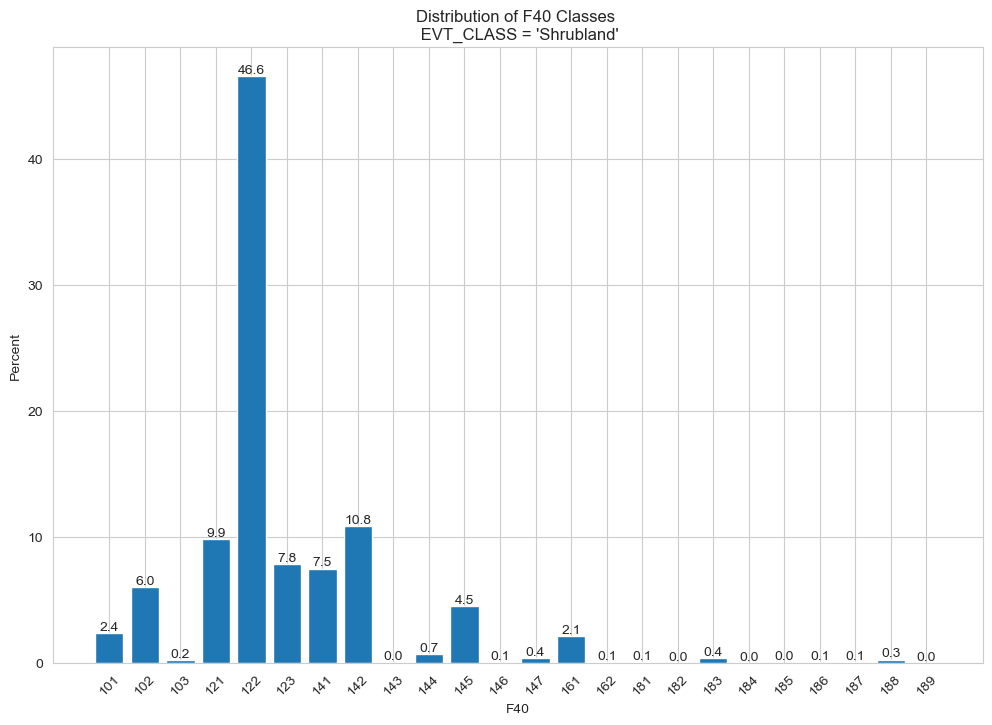

In [8]:
# Look at F40 distribution within EVT_CLASS = Shrubland
df = sample_data.loc[sample_data['EVT_CLASS'] == 'Shrubland'].groupby('F40').count()['FDST'].reset_index().rename(columns={'FDST':'Count'})
df['F40'] = df['F40'].astype('str')
df['Percent'] = df['Count'] / df['Count'].sum() * 100


fig, ax = plt.subplots(figsize=(12,8))
bars = ax.bar(df['F40'],
       df[metric])
ax.set(title="Distribution of F40 Classes \n EVT_CLASS = 'Shrubland'",
       xlabel="F40",
       ylabel=metric)
plt.setp(ax.get_xticklabels(), rotation = 45)
ax.bar_label(bars, fmt='%.1f')  # Add value labels to bars
plt.show()


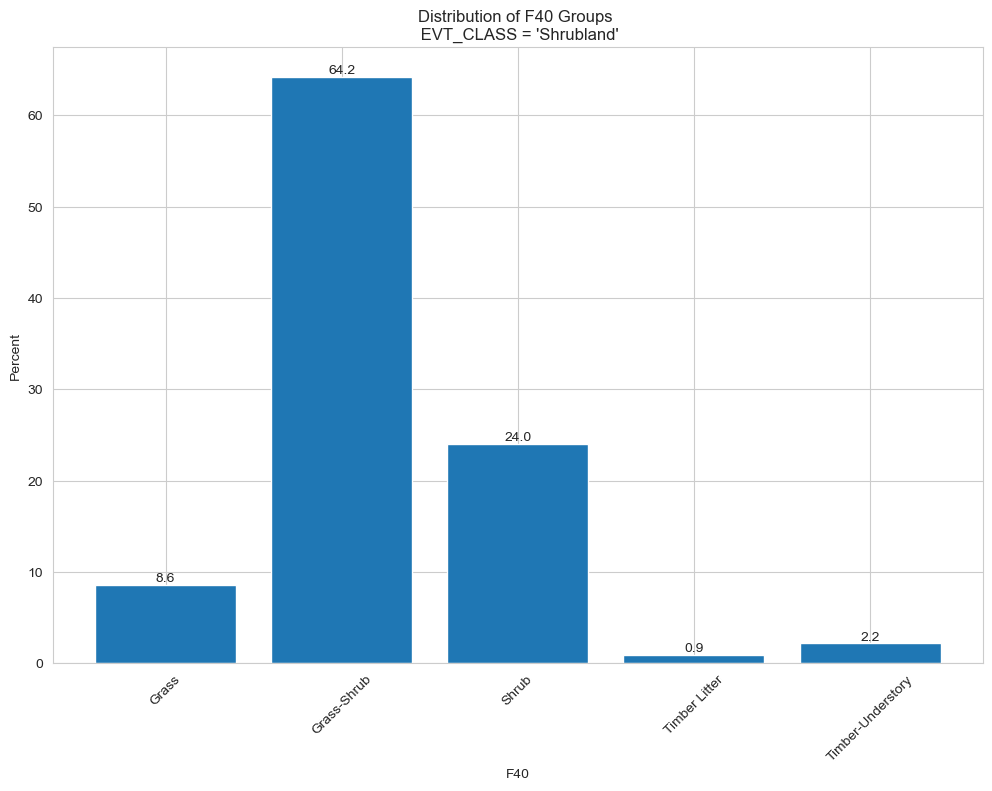

In [9]:
# Look at F40 distribution within EVT_CLASS = Shrubland
df = sample_data.loc[sample_data['EVT_CLASS'] == 'Shrubland'].groupby('F40_GROUP').count()['FDST'].reset_index().rename(columns={'FDST':'Count'})
df['F40_GROUP'] = df['F40_GROUP'].astype('str')
df['Percent'] = df['Count'] / df['Count'].sum() * 100


fig, ax = plt.subplots(figsize=(12,8))
bars = ax.bar(df['F40_GROUP'],
       df[metric])
ax.set(title="Distribution of F40 Groups \n EVT_CLASS = 'Shrubland'",
       xlabel="F40",
       ylabel=metric)
plt.setp(ax.get_xticklabels(), rotation = 45)
ax.bar_label(bars, fmt='%.1f')  # Add value labels to bars
plt.show()

#### EVT_CLASS = Closed Tree Canopy

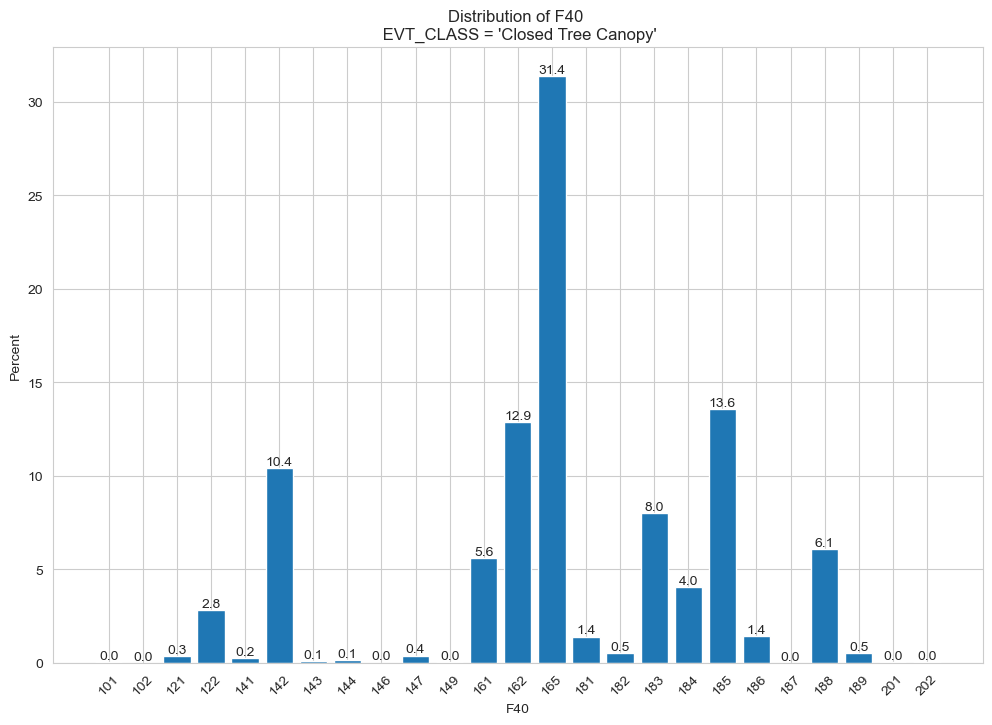

In [10]:
# Look at F40 distribution within EVT_CLASS = Closed Tree Canopy
df = sample_data.loc[sample_data['EVT_CLASS'] == 'Closed tree canopy'].groupby('F40').count()['FDST'].reset_index().rename(columns={'FDST':'Count'})
df['F40'] = df['F40'].astype('str')

df['Percent'] = df['Count'] / df['Count'].sum() * 100

fig, ax = plt.subplots(figsize=(12,8))
bars = ax.bar(df['F40'],
       df[metric])
ax.set(title="Distribution of F40 \n EVT_CLASS = 'Closed Tree Canopy'",
       xlabel="F40",
       ylabel=metric)
plt.setp(ax.get_xticklabels(), rotation = 45)
ax.bar_label(bars, fmt='%.1f')  # Add value labels to bars
plt.show()


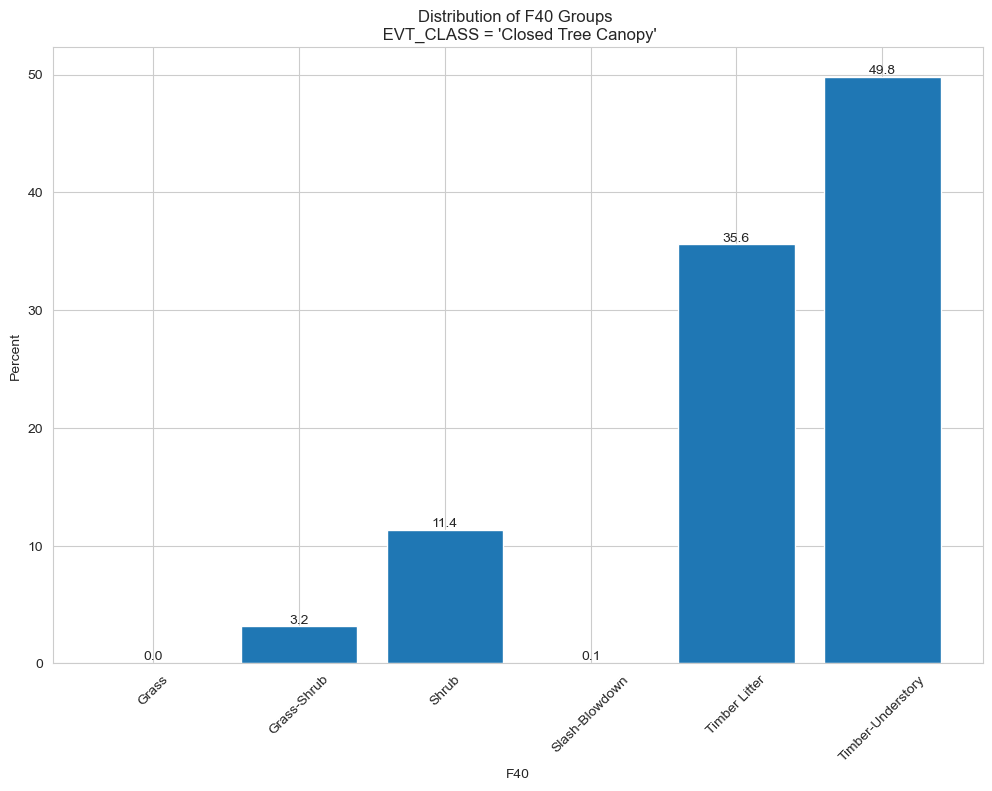

In [11]:
# Look at F40 distribution within EVT_CLASS = Closed Tree Canopy
df = sample_data.loc[sample_data['EVT_CLASS'] == 'Closed tree canopy'].groupby('F40_GROUP').count()['FDST'].reset_index().rename(columns={'FDST':'Count'})
df['F40_GROUP'] = df['F40_GROUP'].astype('str')
df['Percent'] = df['Count'] / df['Count'].sum() * 100


fig, ax = plt.subplots(figsize=(12,8))
bars = ax.bar(df['F40_GROUP'],
       df[metric])
ax.set(title="Distribution of F40 Groups \n EVT_CLASS = 'Closed Tree Canopy'",
       xlabel="F40",
       ylabel=metric)
plt.setp(ax.get_xticklabels(), rotation = 45)
ax.bar_label(bars, fmt='%.1f')  # Add value labels to bars
plt.show()

#### EVT_CLASS = Sparse Tree Canopy

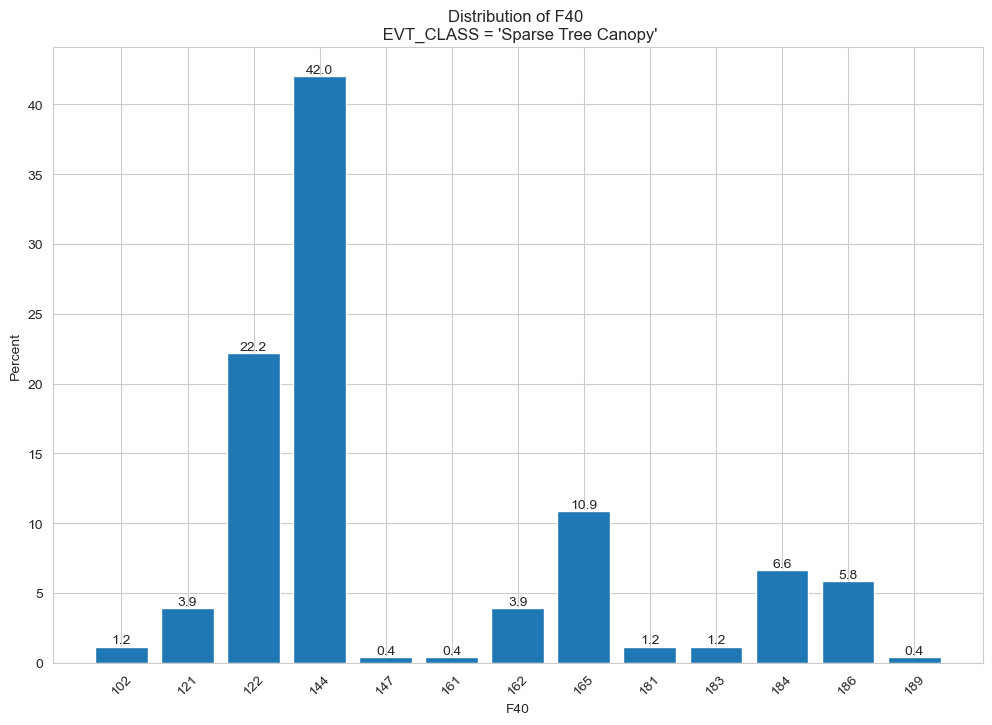

In [12]:
# Look at F40 distribution within EVT_CLASS = Sparse Tree Canopy
df = sample_data.loc[sample_data['EVT_CLASS'] == 'Sparse tree canopy'].groupby('F40').count()['FDST'].reset_index().rename(columns={'FDST':'Count'})
df['F40'] = df['F40'].astype('str')

df['Percent'] = df['Count'] / df['Count'].sum() * 100


fig, ax = plt.subplots(figsize=(12,8))
bars = ax.bar(df['F40'],
       df[metric])
ax.set(title="Distribution of F40 \n EVT_CLASS = 'Sparse Tree Canopy'",
       xlabel="F40",
       ylabel=metric)
plt.setp(ax.get_xticklabels(), rotation = 45)
ax.bar_label(bars, fmt='%.1f')  # Add value labels to bars
plt.show()


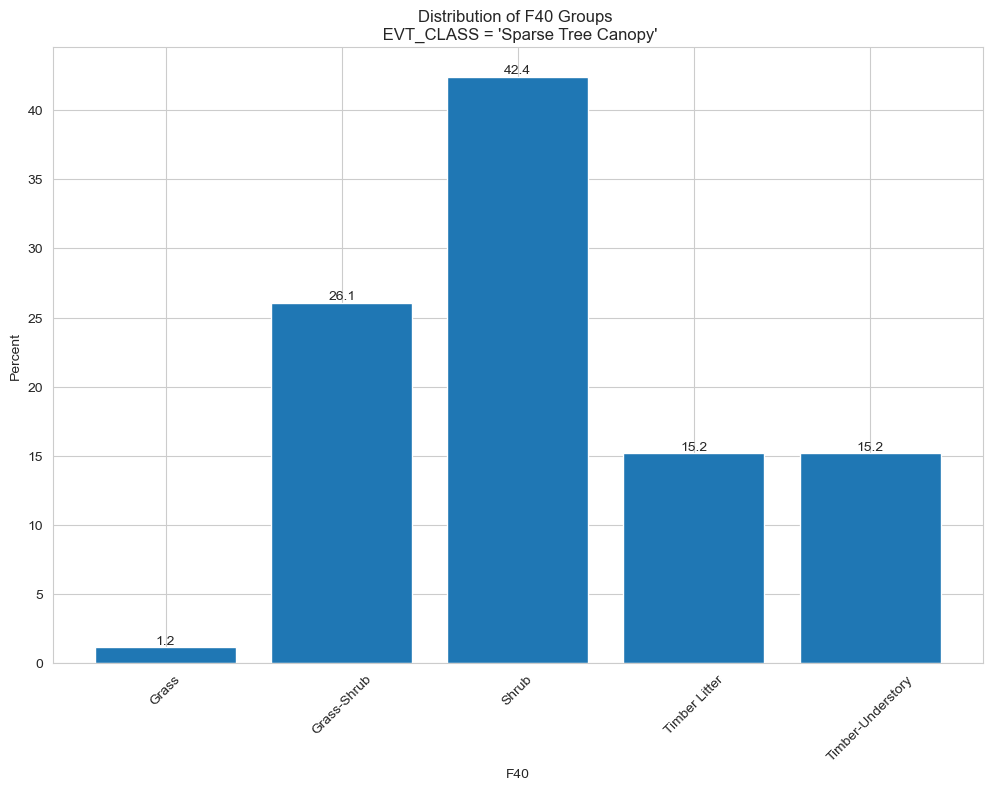

In [13]:
# Look at F40 distribution within EVT_CLASS = Sparse Tree Canopy
df = sample_data.loc[sample_data['EVT_CLASS'] == 'Sparse tree canopy'].groupby('F40_GROUP').count()['FDST'].reset_index().rename(columns={'FDST':'Count'})
df['F40_GROUP'] = df['F40_GROUP'].astype('str')
df['Percent'] = df['Count'] / df['Count'].sum() * 100


fig, ax = plt.subplots(figsize=(12,8))
bars = ax.bar(df['F40_GROUP'],
       df[metric])
ax.set(title="Distribution of F40 Groups \n EVT_CLASS = 'Sparse Tree Canopy'",
       xlabel="F40",
       ylabel=metric)
plt.setp(ax.get_xticklabels(), rotation = 45)
ax.bar_label(bars, fmt='%.1f')  # Add value labels to bars
plt.show()

#### EVT_CLASS = Other
Options: 
1. Sparsely Vegetated
2. Dwarf-shrubland
3. Herbaceous - grassland
4. Herbaceous - shrub-steppe

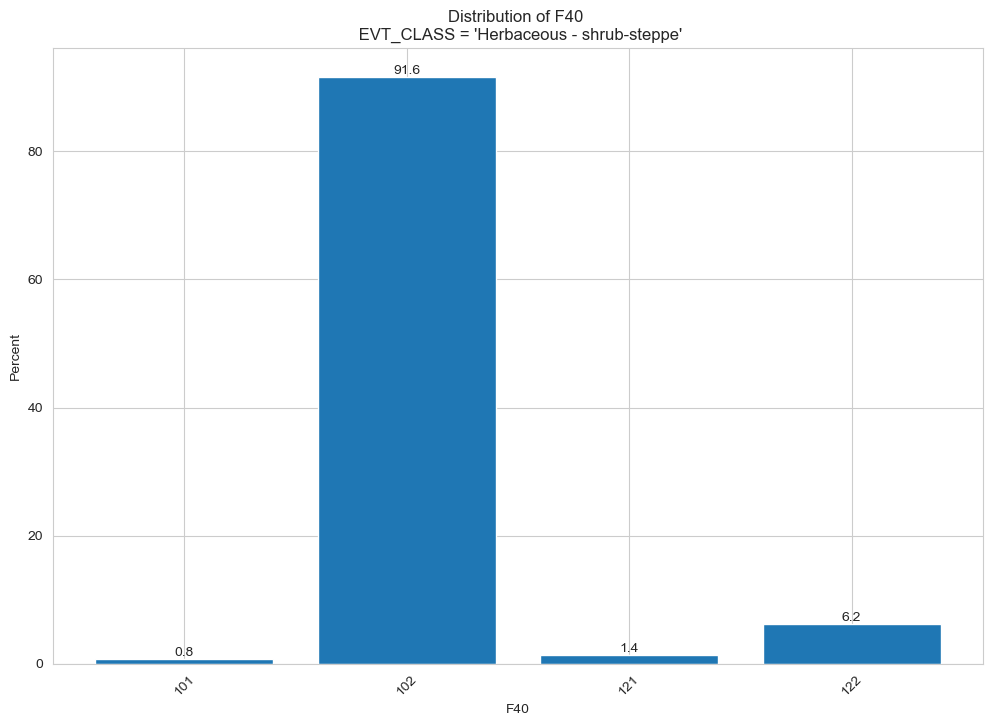

In [14]:
# Look at F40 distribution within EVT_CLASS
df = sample_data.loc[sample_data['EVT_CLASS'] == 'Herbaceous - shrub-steppe'].groupby('F40').count()['FDST'].reset_index().rename(columns={'FDST':'Count'})
df['F40'] = df['F40'].astype('str')

df['Percent'] = df['Count'] / df['Count'].sum() * 100


fig, ax = plt.subplots(figsize=(12,8))
bars = ax.bar(df['F40'],
       df[metric])
ax.set(title="Distribution of F40 \n EVT_CLASS = 'Herbaceous - shrub-steppe'",
       xlabel="F40",
       ylabel=metric)
plt.setp(ax.get_xticklabels(), rotation = 45)
ax.bar_label(bars, fmt='%.1f')  # Add value labels to bars
plt.show()

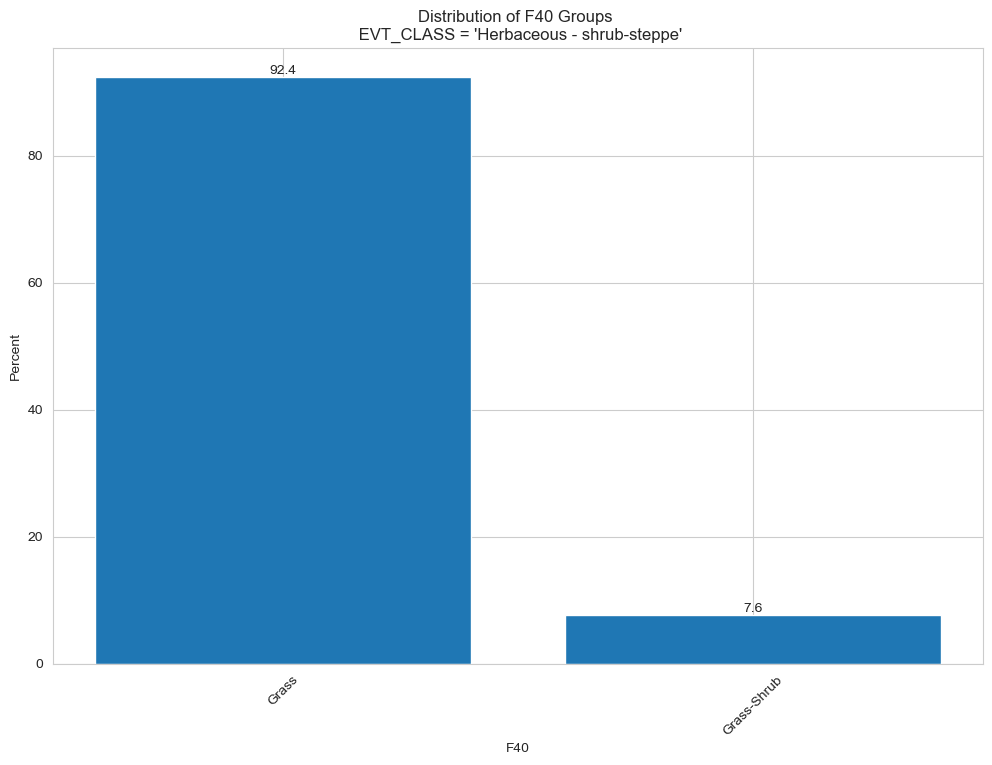

In [15]:
# Look at F40 distribution within EVT_CLASS = Sparse Tree Canopy
df = sample_data.loc[sample_data['EVT_CLASS'] == 'Herbaceous - shrub-steppe'].groupby('F40_GROUP').count()['FDST'].reset_index().rename(columns={'FDST':'Count'})
df['F40_GROUP'] = df['F40_GROUP'].astype('str')
df['Percent'] = df['Count'] / df['Count'].sum() * 100


fig, ax = plt.subplots(figsize=(12,8))
bars = ax.bar(df['F40_GROUP'],
       df[metric])
ax.set(title="Distribution of F40 Groups \n EVT_CLASS = 'Herbaceous - shrub-steppe'",
       xlabel="F40",
       ylabel=metric)
plt.setp(ax.get_xticklabels(), rotation = 45)
ax.bar_label(bars, fmt='%.1f')  # Add value labels to bars
plt.show()

## Compare Sample Points F40 distribution with F40 Layer distribution
Confirm that the sample distribution of F40 classes is in line with the distribution from the source layer.

-----

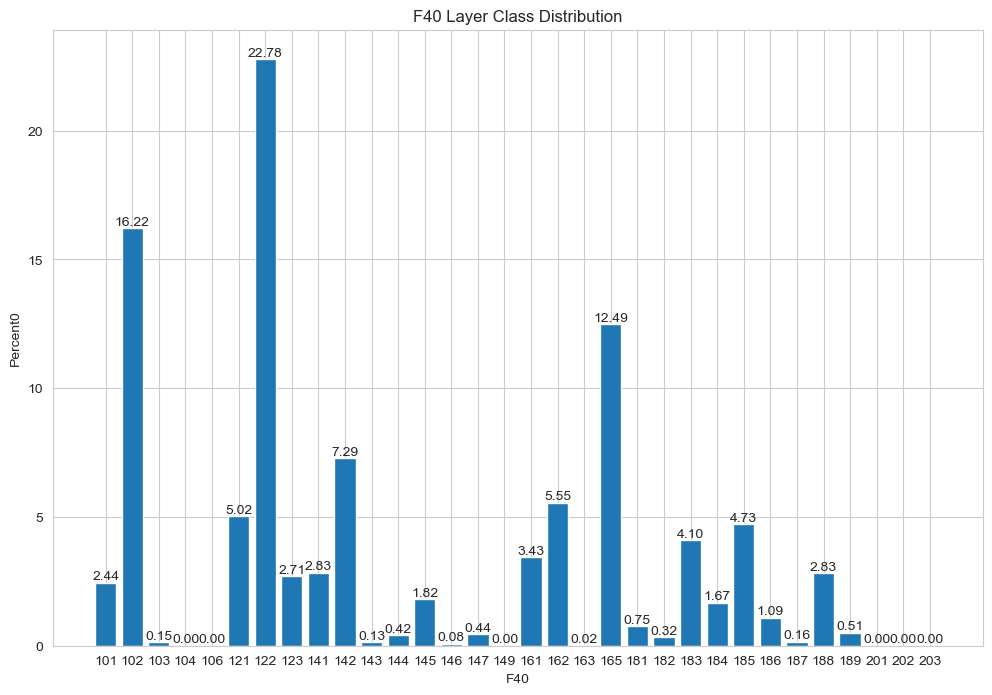

In [16]:
F40_layer_path = r"C:\Users\mcco573\OneDrive - PNNL\Desktop\temp_files\LC22_F40_230_bpa.csv"
F40_layer = pd.read_csv(F40_layer_path)
F40_layer = F40_layer.loc[~F40_layer['Value'].isin([-9999, 91, 92, 93, 98,99])]  # Drop NULLS and Nonburnable

F40_layer['Percent'] = F40_layer['Count'] / F40_layer['Count'].sum() * 100

fig, ax = plt.subplots(figsize=(12,8))
F40_layer['Value'] = F40_layer['Value'].astype('str')
ax.set(title="F40 Layer Class Distribution",
       xlabel="F40",
       ylabel="Percent0")
bars = ax.bar(F40_layer['Value'],
       F40_layer['Percent'])
ax.bar_label(bars, fmt='%.2f')  # Add value labels to bars
plt.show()

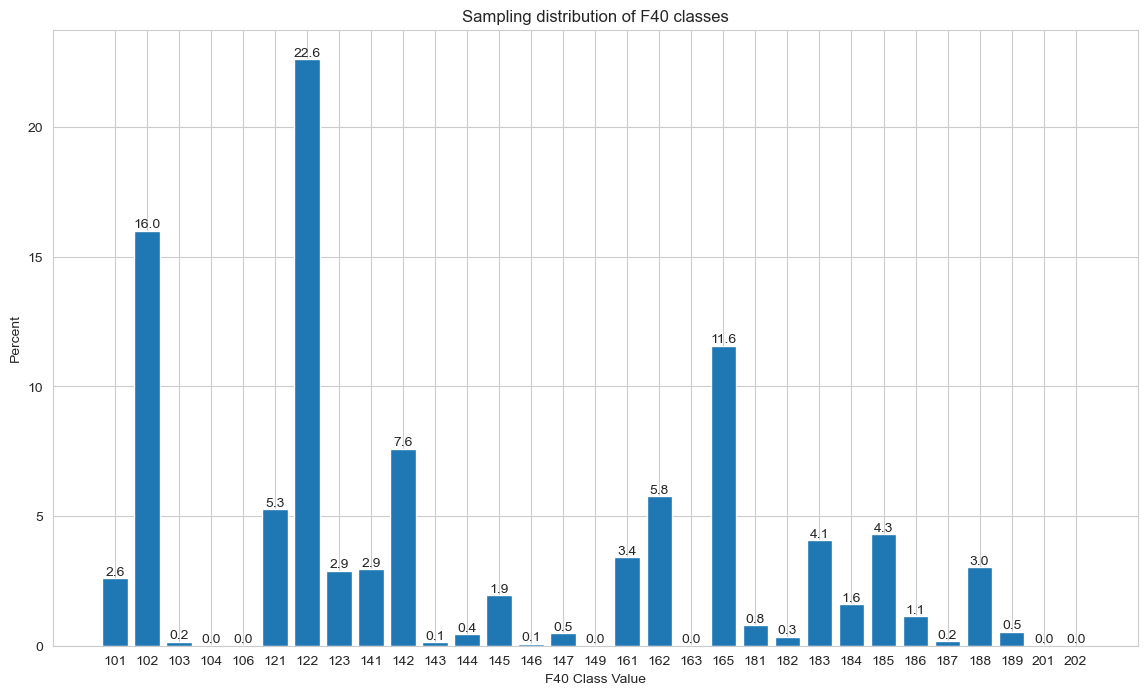

In [17]:
f40_fig

# Model Misclass Distributions

---------

## HGBC without F40_GROUP
Accuracy = 68.9%

- Imbalance Correction = None

- Run = 179 : ['FVC_TREE', 'FVC_SHRUB', 'FVC_HERB', 'FVC_OTHER', 'FVH_TREE', 'FVH_SHRUB', 'FVH_HERB', 'FVH_OTHER', 'PYROME', 'EVT_SBLCS', 'BPS_FRG_NEW', 'ASPECT', 'ELEVATION', 'SLOPE', 'F40_GROUP']

In [18]:
model_pred_path = r"C:\Users\mcco573\OneDrive - PNNL\Documents\_Projects\BPA Wildfire\F40 Random Forest Model\model_results\model_predictions_2024-03-08\HGBC_Preds_run-179_GROUP-False_weight-None.csv"
model_preds = pd.read_csv(model_pred_path)

metric='Count'

model_preds.head()

,Unnamed: 0,FVC_TREE,FVC_SHRUB,FVC_HERB,FVC_OTHER,FVH_TREE,FVH_SHRUB,FVH_HERB,FVH_OTHER,PYROME,EVT_SBLCS,BPS_FRG_NEW,ASPECT,ELEVATION,SLOPE,F40,F40-predicted
0,88987,104,0,0,0,619,0,0,0,7.0,NaN,7,159,1304,9,188,188
1,29427,0,113,0,0,0,507,0,0,13.0,Mixed evergreen-deciduous shrubland,8,-1,1909,2,122,122
2,37797,0,112,0,0,0,520,0,0,19.0,Evergreen shrubland,8,-1,1316,0,142,142
3,74236,106,0,0,0,619,0,0,0,9.0,Evergreen closed tree canopy,2,58,1393,30,142,162
4,22174,102,0,0,0,607,0,0,0,20.0,Evergreen open tree canopy,2,271,1708,37,122,122


In [19]:
# Extract misclassed rows and add difference column
misclasses = model_preds.loc[model_preds['F40'] != model_preds['F40-predicted']]
misclasses = misclasses[['F40', 'F40-predicted']].rename(columns={'F40-predicted':'Predicted'})
misclasses['diff'] = misclasses['F40'] - misclasses['Predicted']



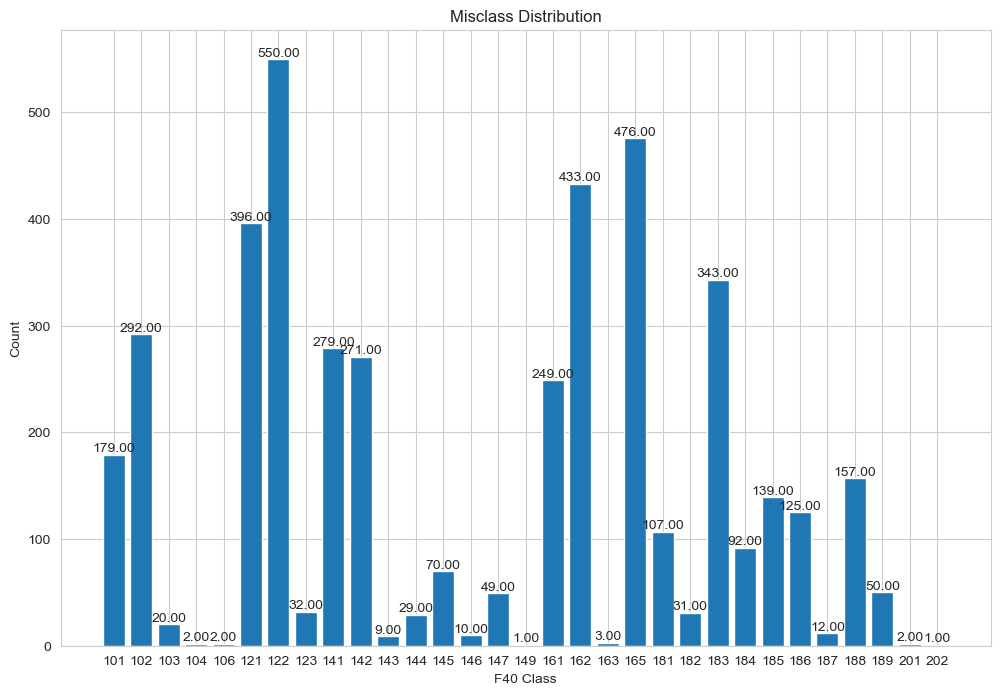

In [20]:
# Look at where misclasses are occurring 
## Aggregate which classes are being misclassed
misclass_grouped = misclasses.groupby('F40').count()['Predicted'].reset_index().rename(columns={'Predicted':'Count'})
misclass_grouped['F40'] = misclass_grouped['F40'].astype('str')
misclass_grouped['Percent'] = misclass_grouped['Count'] / misclass_grouped['Count'].sum() * 100

## Visualize the distribution
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(misclass_grouped['F40'],
              misclass_grouped[metric])
ax.set(title='Misclass Distribution',
       xlabel='F40 Class',
       ylabel=metric)
ax.bar_label(bars, fmt='%.2f')
plt.show()


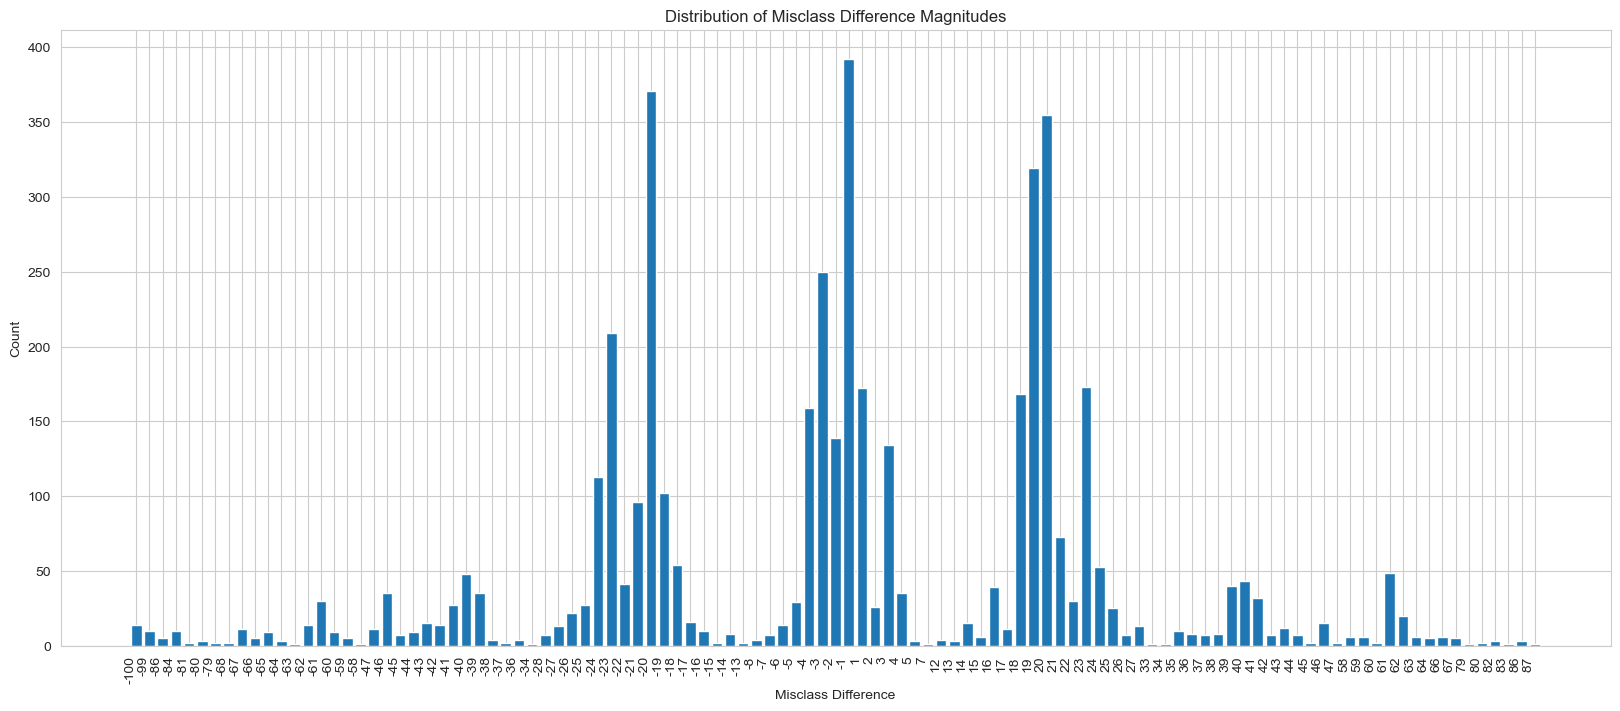

In [21]:
# Look at how far off the misclasses typically are
## Note that there are break between F40 "Classes" (e.g. GR vs. GS)

misclass_diff_grouped = misclasses.groupby('diff').count()['F40'].reset_index().rename(columns={'F40':'Count'})
misclass_diff_grouped['diff'] = misclass_diff_grouped['diff'].astype('str')

fig, ax = plt.subplots(figsize=(20,8))
bars = ax.bar(misclass_diff_grouped['diff'],
              misclass_diff_grouped['Count'])
ax.set(title='Distribution of Misclass Difference Magnitudes',
       xlabel="Misclass Difference",
       ylabel="Count")
plt.xticks(rotation='vertical', ha='right')
#ax.bar_label(bars, fmt="%.2f")
plt.show()

## HGBC with F40_GROUP
Accuracy = 83.7%

- Imbalance Correction = None

- Run = 179 : ['FVC_TREE', 'FVC_SHRUB', 'FVC_HERB', 'FVC_OTHER', 'FVH_TREE', 'FVH_SHRUB', 'FVH_HERB', 'FVH_OTHER', 'PYROME', 'EVT_SBLCS', 'BPS_FRG_NEW', 'ASPECT', 'ELEVATION', 'SLOPE', 'F40_GROUP']

In [22]:
model_pred_path = r"C:\Users\mcco573\OneDrive - PNNL\Documents\_Projects\BPA Wildfire\F40 Random Forest Model\model_results\model_predictions_2024-03-08\HGBC_Preds_run-179_GROUP-True_weight-None.csv"
model_preds = pd.read_csv(model_pred_path)

metric='Count'

model_preds.head()

,Unnamed: 0,FVC_TREE,FVC_SHRUB,FVC_HERB,FVC_OTHER,FVH_TREE,FVH_SHRUB,FVH_HERB,FVH_OTHER,PYROME,EVT_SBLCS,BPS_FRG_NEW,ASPECT,ELEVATION,SLOPE,F40_GROUP,F40,F40-predicted
0,88987,104,0,0,0,619,0,0,0,7.0,NaN,7,159,1304,9,Timber Litter,188,188
1,29427,0,113,0,0,0,507,0,0,13.0,Mixed evergreen-deciduous shrubland,8,-1,1909,2,Grass-Shrub,122,122
2,37797,0,112,0,0,0,520,0,0,19.0,Evergreen shrubland,8,-1,1316,0,Shrub,142,142
3,74236,106,0,0,0,619,0,0,0,9.0,Evergreen closed tree canopy,2,58,1393,30,Shrub,142,142
4,22174,102,0,0,0,607,0,0,0,20.0,Evergreen open tree canopy,2,271,1708,37,Grass-Shrub,122,122


In [23]:
# Extract misclassed rows and add difference column
misclasses = model_preds.loc[model_preds['F40'] != model_preds['F40-predicted']]
misclasses = misclasses[['F40', 'F40-predicted']].rename(columns={'F40-predicted':'Predicted'})
misclasses['diff'] = misclasses['F40'] - misclasses['Predicted']



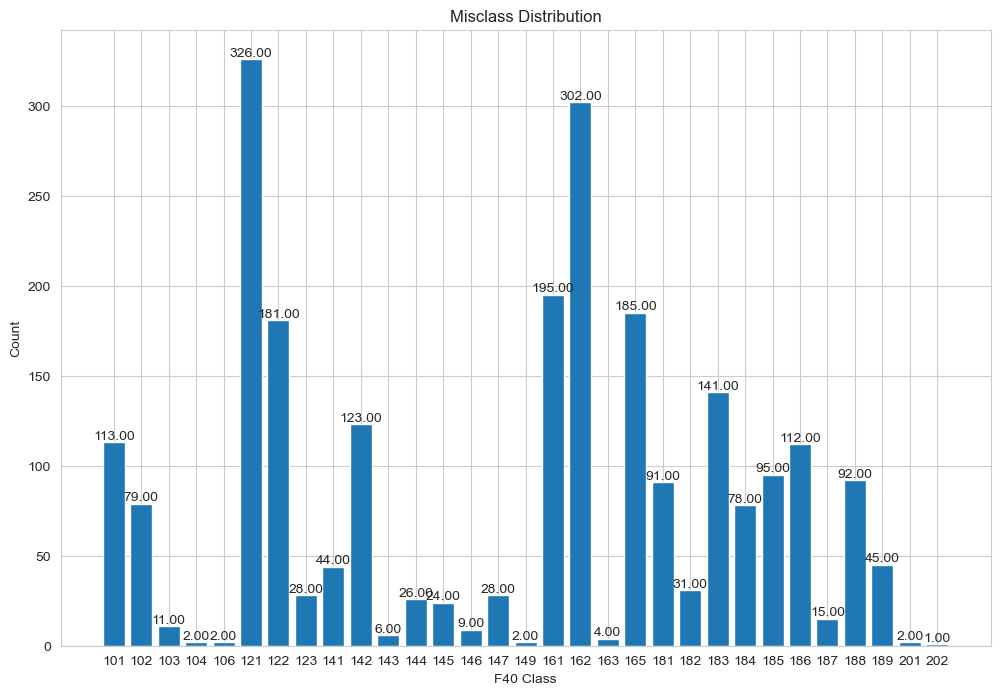

In [24]:
# Look at where misclasses are occurring 
## Aggregate which classes are being misclassed
misclass_grouped = misclasses.groupby('F40').count()['Predicted'].reset_index().rename(columns={'Predicted':'Count'})
misclass_grouped['F40'] = misclass_grouped['F40'].astype('str')
misclass_grouped['Percent'] = misclass_grouped['Count'] / misclass_grouped['Count'].sum() * 100

## Visualize the distribution
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(misclass_grouped['F40'],
              misclass_grouped[metric])
ax.set(title='Misclass Distribution',
       xlabel='F40 Class',
       ylabel=metric)
ax.bar_label(bars, fmt='%.2f')
plt.show()


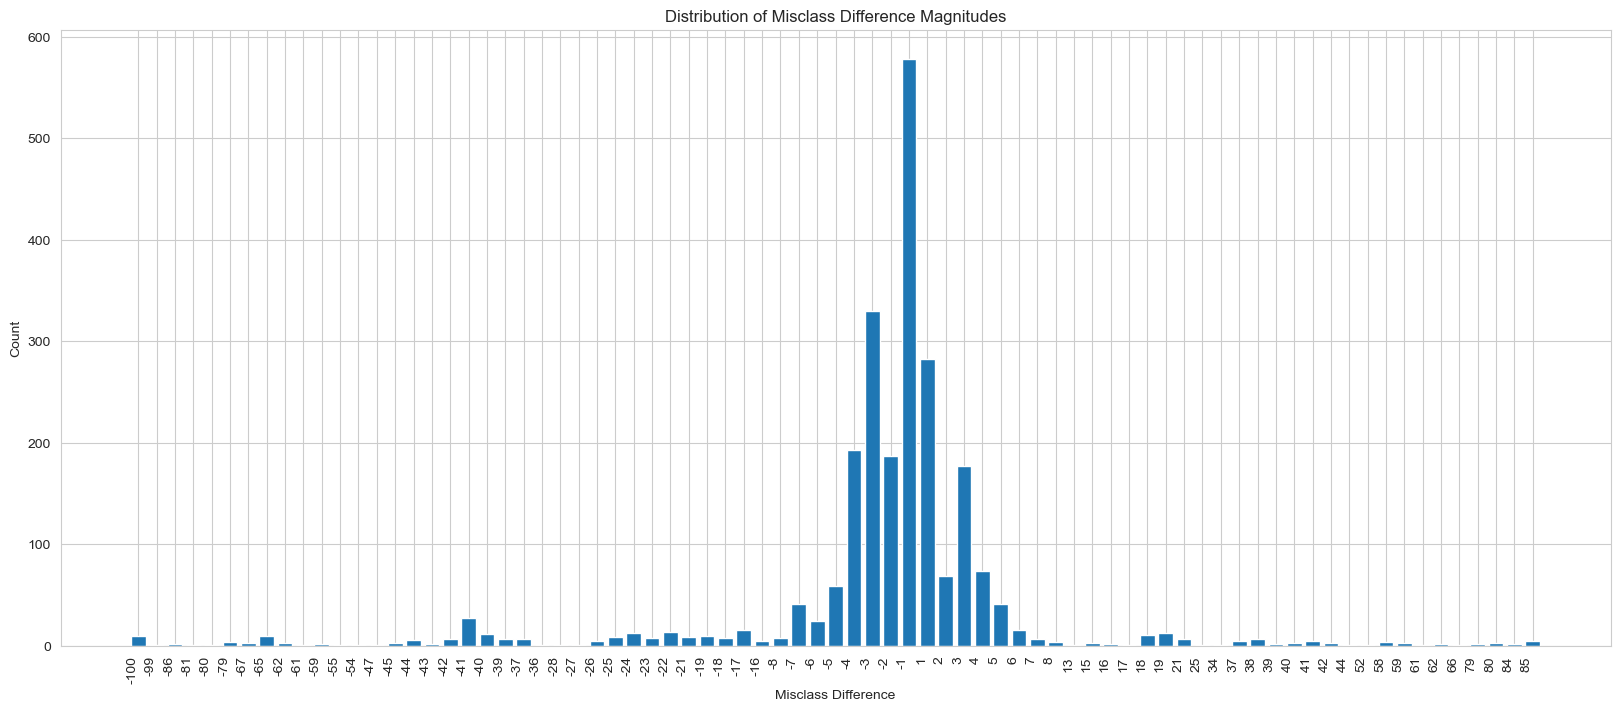

In [25]:
# Look at how far off the misclasses typically are
## Note that there are break between F40 "Classes" (e.g. GR vs. GS)

misclass_diff_grouped = misclasses.groupby('diff').count()['F40'].reset_index().rename(columns={'F40':'Count'})
misclass_diff_grouped['diff'] = misclass_diff_grouped['diff'].astype('str')

fig, ax = plt.subplots(figsize=(20,8))
bars = ax.bar(misclass_diff_grouped['diff'],
              misclass_diff_grouped['Count'])
ax.set(title='Distribution of Misclass Difference Magnitudes',
       xlabel="Misclass Difference",
       ylabel="Count")
plt.xticks(rotation='vertical', ha='right')
#ax.bar_label(bars, fmt="%.2f")
plt.show()

## Train on LF22 and Predict on LF23 - Without F40_GROUP
Accuracy = 73.3%

- Imbalance Correction = None

- Run = 179 : ['FVC_TREE', 'FVC_SHRUB', 'FVC_HERB', 'FVC_OTHER', 'FVH_TREE', 'FVH_SHRUB', 'FVH_HERB', 'FVH_OTHER', 'PYROME', 'EVT_SBLCS', 'BPS_FRG_NEW', 'ASPECT', 'ELEVATION', 'SLOPE', 'F40_GROUP']

In [26]:
model_pred_path = r"C:\Users\mcco573\OneDrive - PNNL\Documents\_Projects\BPA Wildfire\F40 Random Forest Model\model_results\model_predictions_2024-03-08\Train-LF22_Predict-LF23_HGBC_Preds_run-179_GROUP-False_weight-None.csv"
model_preds = pd.read_csv(model_pred_path)

metric='Count'

model_preds.head()

,Unnamed: 0,FVC_TREE,FVC_SHRUB,FVC_HERB,FVC_OTHER,FVH_TREE,FVH_SHRUB,FVH_HERB,FVH_OTHER,PYROME,EVT_SBLCS,BPS_FRG_NEW,ASPECT,ELEVATION,SLOPE,F40,F40-predicted
0,0,0,0,124,0,0,0,425,0,31.0,Mixed evergreen-deciduous shrubland,2,62,274,3,102,102
1,2,0,0,125,0,0,0,425,0,32.0,Annual Graminoid/Forb,6,-1,303,0,102,102
2,3,105,0,0,0,623,0,0,0,32.0,Evergreen open tree canopy,8,279,453,20,165,165
3,4,0,0,126,0,0,0,425,0,32.0,Annual Graminoid/Forb,6,-1,297,0,102,102
4,5,106,0,0,0,627,0,0,0,32.0,Evergreen open tree canopy,6,110,895,19,182,165


In [27]:
# Extract misclassed rows and add difference column
misclasses = model_preds.loc[model_preds['F40'] != model_preds['F40-predicted']]
misclasses = misclasses[['F40', 'F40-predicted']].rename(columns={'F40-predicted':'Predicted'})
misclasses['diff'] = misclasses['F40'] - misclasses['Predicted']



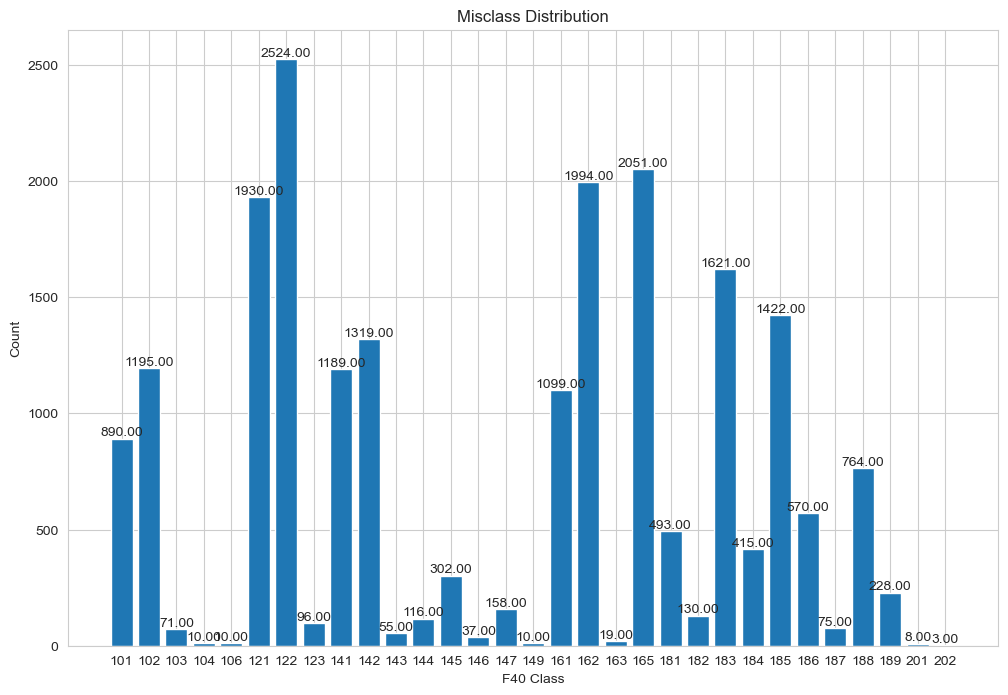

In [28]:
# Look at where misclasses are occurring 
## Aggregate which classes are being misclassed
misclass_grouped = misclasses.groupby('F40').count()['Predicted'].reset_index().rename(columns={'Predicted':'Count'})
misclass_grouped['F40'] = misclass_grouped['F40'].astype('str')
misclass_grouped['Percent'] = misclass_grouped['Count'] / misclass_grouped['Count'].sum() * 100

## Visualize the distribution
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(misclass_grouped['F40'],
              misclass_grouped[metric])
ax.set(title='Misclass Distribution',
       xlabel='F40 Class',
       ylabel=metric)
ax.bar_label(bars, fmt='%.2f')
plt.show()


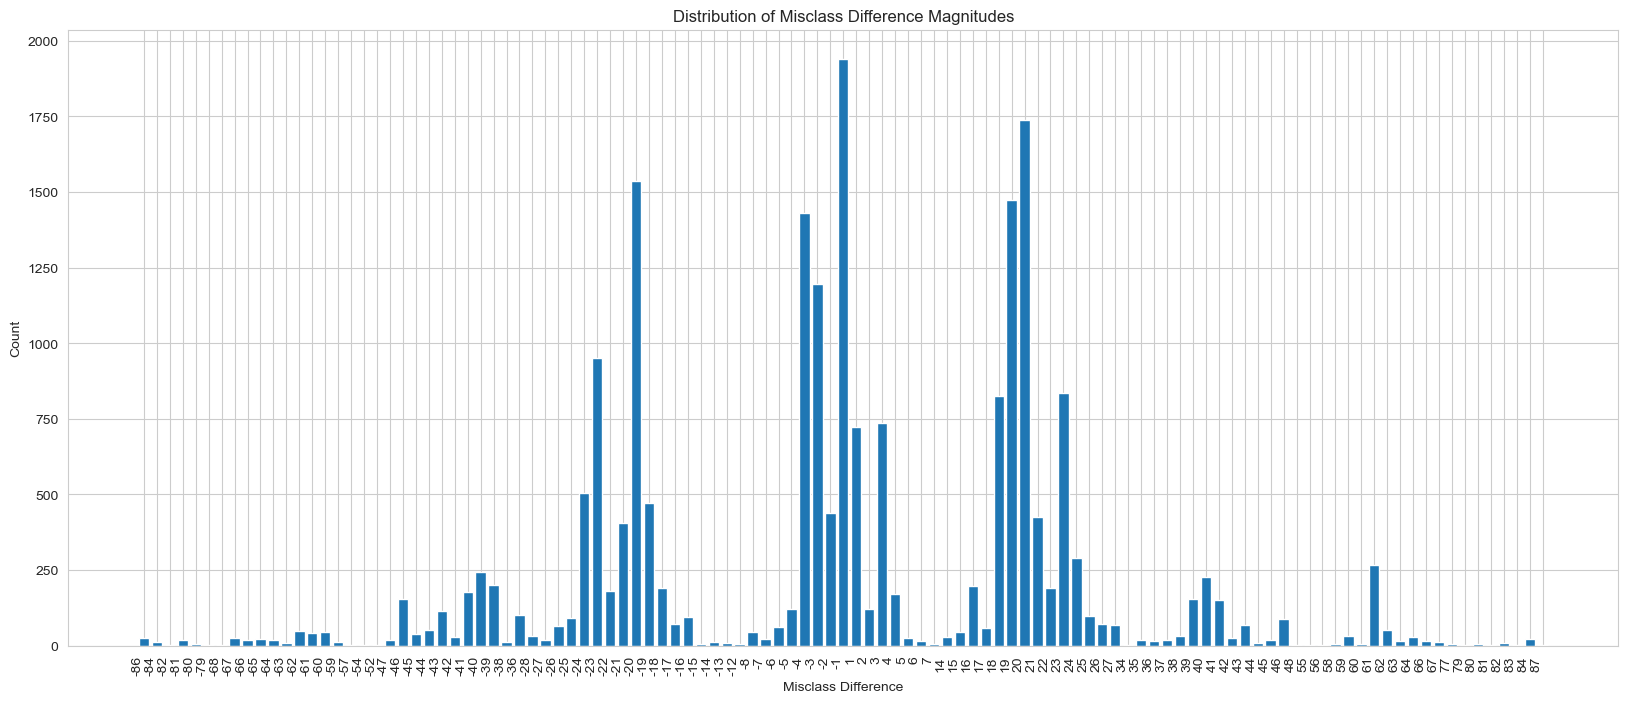

In [29]:
# Look at how far off the misclasses typically are
## Note that there are break between F40 "Classes" (e.g. GR vs. GS)

misclass_diff_grouped = misclasses.groupby('diff').count()['F40'].reset_index().rename(columns={'F40':'Count'})
misclass_diff_grouped['diff'] = misclass_diff_grouped['diff'].astype('str')

fig, ax = plt.subplots(figsize=(20,8))
bars = ax.bar(misclass_diff_grouped['diff'],
              misclass_diff_grouped['Count'])
ax.set(title='Distribution of Misclass Difference Magnitudes',
       xlabel="Misclass Difference",
       ylabel="Count")
plt.xticks(rotation='vertical', ha='right')
#ax.bar_label(bars, fmt="%.2f")
plt.show()

## Train on LF22 and Predict on LF23 - With F40_GROUP
Accuracy = 85.4%

- Imbalance Correction = None

- Run = 179 : ['FVC_TREE', 'FVC_SHRUB', 'FVC_HERB', 'FVC_OTHER', 'FVH_TREE', 'FVH_SHRUB', 'FVH_HERB', 'FVH_OTHER', 'PYROME', 'EVT_SBLCS', 'BPS_FRG_NEW', 'ASPECT', 'ELEVATION', 'SLOPE', 'F40_GROUP']

In [30]:
model_pred_path = r"C:\Users\mcco573\OneDrive - PNNL\Documents\_Projects\BPA Wildfire\F40 Random Forest Model\model_results\model_predictions_2024-03-08\Train-LF22_Predict-LF23_HGBC_Preds_run-179_GROUP-True_weight-None.csv"
model_preds = pd.read_csv(model_pred_path)

metric='Count'

model_preds.head()

,Unnamed: 0,FVC_TREE,FVC_SHRUB,FVC_HERB,FVC_OTHER,FVH_TREE,FVH_SHRUB,FVH_HERB,FVH_OTHER,PYROME,EVT_SBLCS,BPS_FRG_NEW,ASPECT,ELEVATION,SLOPE,F40_GROUP,F40,F40-predicted
0,0,0,0,124,0,0,0,425,0,31.0,Mixed evergreen-deciduous shrubland,2,62,274,3,Grass,102,102
1,2,0,0,125,0,0,0,425,0,32.0,Annual Graminoid/Forb,6,-1,303,0,Grass,102,102
2,3,105,0,0,0,623,0,0,0,32.0,Evergreen open tree canopy,8,279,453,20,Timber-Understory,165,165
3,4,0,0,126,0,0,0,425,0,32.0,Annual Graminoid/Forb,6,-1,297,0,Grass,102,102
4,5,106,0,0,0,627,0,0,0,32.0,Evergreen open tree canopy,6,110,895,19,Timber Litter,182,182


In [31]:
# Extract misclassed rows and add difference column
misclasses = model_preds.loc[model_preds['F40'] != model_preds['F40-predicted']]
misclasses = misclasses[['F40', 'F40-predicted']].rename(columns={'F40-predicted':'Predicted'})
misclasses['diff'] = misclasses['F40'] - misclasses['Predicted']



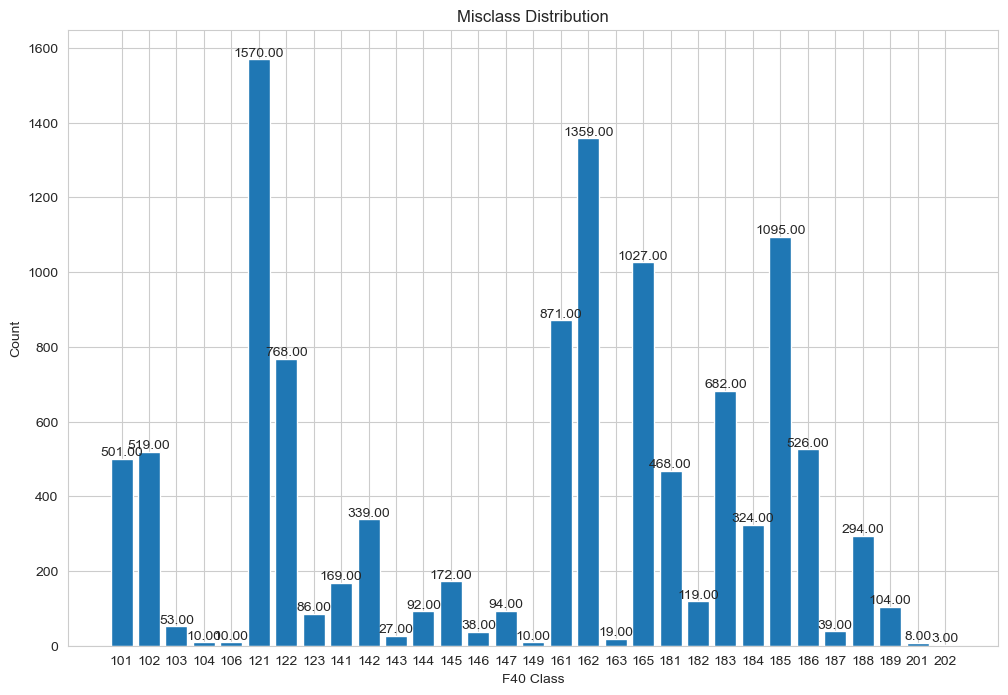

In [32]:
# Look at where misclasses are occurring 
## Aggregate which classes are being misclassed
misclass_grouped = misclasses.groupby('F40').count()['Predicted'].reset_index().rename(columns={'Predicted':'Count'})
misclass_grouped['F40'] = misclass_grouped['F40'].astype('str')
misclass_grouped['Percent'] = misclass_grouped['Count'] / misclass_grouped['Count'].sum() * 100

## Visualize the distribution
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(misclass_grouped['F40'],
              misclass_grouped[metric])
ax.set(title='Misclass Distribution',
       xlabel='F40 Class',
       ylabel=metric)
ax.bar_label(bars, fmt='%.2f')
plt.show()


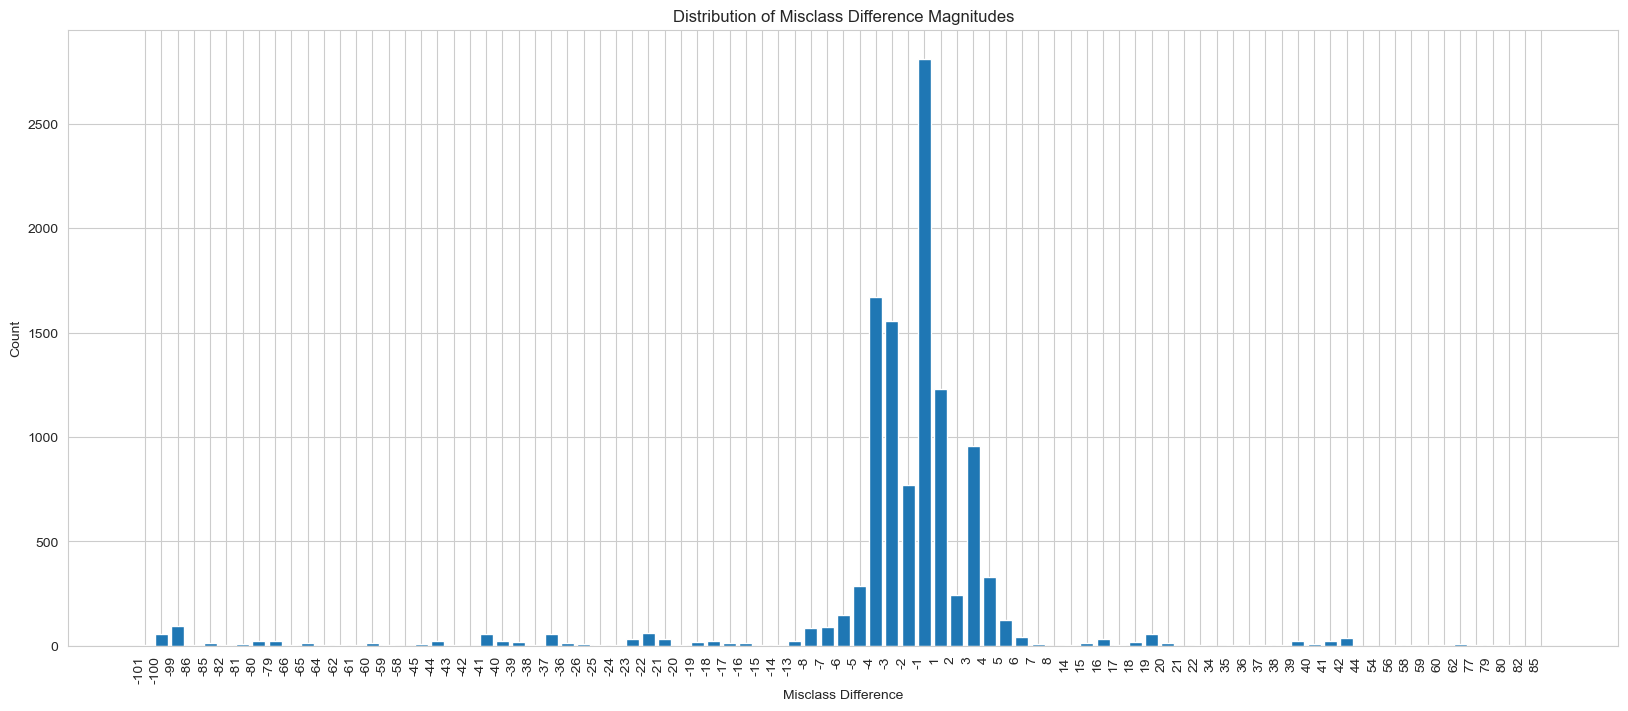

In [33]:
# Look at how far off the misclasses typically are
## Note that there are break between F40 "Classes" (e.g. GR vs. GS)

misclass_diff_grouped = misclasses.groupby('diff').count()['F40'].reset_index().rename(columns={'F40':'Count'})
misclass_diff_grouped['diff'] = misclass_diff_grouped['diff'].astype('str')

fig, ax = plt.subplots(figsize=(20,8))
bars = ax.bar(misclass_diff_grouped['diff'],
              misclass_diff_grouped['Count'])
ax.set(title='Distribution of Misclass Difference Magnitudes',
       xlabel="Misclass Difference",
       ylabel="Count")
plt.xticks(rotation='vertical', ha='right')
#ax.bar_label(bars, fmt="%.2f")
plt.show()

## Train on LF23 and Predict on LF22 - Without F40_GROUP
Accuracy = 73.6%

- Imbalance Correction = None

- Run = 179 : ['FVC_TREE', 'FVC_SHRUB', 'FVC_HERB', 'FVC_OTHER', 'FVH_TREE', 'FVH_SHRUB', 'FVH_HERB', 'FVH_OTHER', 'PYROME', 'EVT_SBLCS', 'BPS_FRG_NEW', 'ASPECT', 'ELEVATION', 'SLOPE', 'F40_GROUP']

In [34]:
model_pred_path = r"C:\Users\mcco573\OneDrive - PNNL\Documents\_Projects\BPA Wildfire\F40 Random Forest Model\model_results\model_predictions_2024-03-08\Train-LF23_Predict-LF22_HGBC_Preds_run-179_GROUP-False_weight-None.csv"
model_preds = pd.read_csv(model_pred_path)

metric='Count'

model_preds.head()

,Unnamed: 0,FVC_TREE,FVC_SHRUB,FVC_HERB,FVC_OTHER,FVH_TREE,FVH_SHRUB,FVH_HERB,FVH_OTHER,PYROME,EVT_SBLCS,BPS_FRG_NEW,ASPECT,ELEVATION,SLOPE,F40,F40-predicted
0,0,0,0,124,0,0,0,425,0,31.0,Mixed evergreen-deciduous shrubland,2,62,274,3,102,102
1,2,0,0,125,0,0,0,425,0,32.0,Annual Graminoid/Forb,6,-1,303,0,102,102
2,3,105,0,0,0,623,0,0,0,32.0,Evergreen open tree canopy,8,279,453,20,165,165
3,4,0,0,126,0,0,0,425,0,32.0,Annual Graminoid/Forb,6,-1,297,0,102,103
4,5,106,0,0,0,627,0,0,0,32.0,Evergreen open tree canopy,6,110,895,19,182,187


In [35]:
# Extract misclassed rows and add difference column
misclasses = model_preds.loc[model_preds['F40'] != model_preds['F40-predicted']]
misclasses = misclasses[['F40', 'F40-predicted']].rename(columns={'F40-predicted':'Predicted'})
misclasses['diff'] = misclasses['F40'] - misclasses['Predicted']



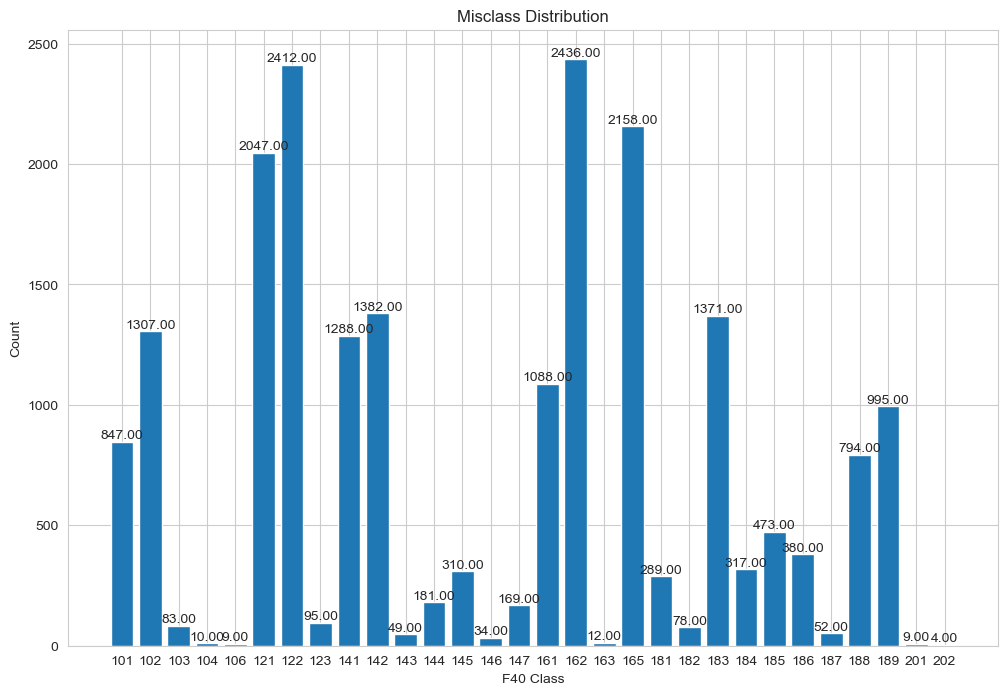

In [36]:
# Look at where misclasses are occurring 
## Aggregate which classes are being misclassed
misclass_grouped = misclasses.groupby('F40').count()['Predicted'].reset_index().rename(columns={'Predicted':'Count'})
misclass_grouped['F40'] = misclass_grouped['F40'].astype('str')
misclass_grouped['Percent'] = misclass_grouped['Count'] / misclass_grouped['Count'].sum() * 100

## Visualize the distribution
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(misclass_grouped['F40'],
              misclass_grouped[metric])
ax.set(title='Misclass Distribution',
       xlabel='F40 Class',
       ylabel=metric)
ax.bar_label(bars, fmt='%.2f')
plt.show()


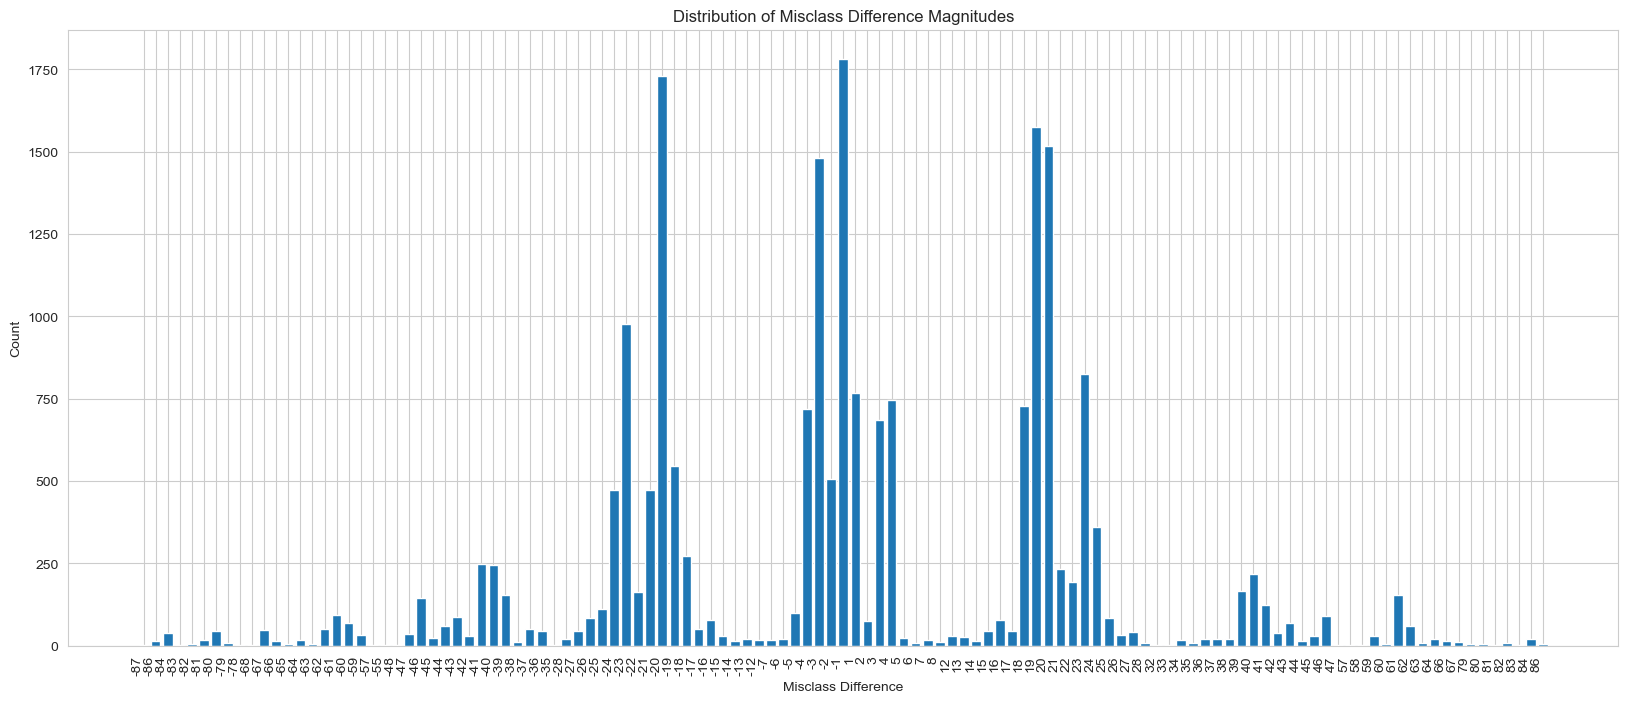

In [37]:
# Look at how far off the misclasses typically are
## Note that there are break between F40 "Classes" (e.g. GR vs. GS)

misclass_diff_grouped = misclasses.groupby('diff').count()['F40'].reset_index().rename(columns={'F40':'Count'})
misclass_diff_grouped['diff'] = misclass_diff_grouped['diff'].astype('str')

fig, ax = plt.subplots(figsize=(20,8))
bars = ax.bar(misclass_diff_grouped['diff'],
              misclass_diff_grouped['Count'])
ax.set(title='Distribution of Misclass Difference Magnitudes',
       xlabel="Misclass Difference",
       ylabel="Count")
plt.xticks(rotation='vertical', ha='right')
#ax.bar_label(bars, fmt="%.2f")
plt.show()

## Train on LF23 and Predict on LF22 - With F40_GROUP
Accuracy = 85.6%

- Imbalance Correction = None

- Run = 179 : ['FVC_TREE', 'FVC_SHRUB', 'FVC_HERB', 'FVC_OTHER', 'FVH_TREE', 'FVH_SHRUB', 'FVH_HERB', 'FVH_OTHER', 'PYROME', 'EVT_SBLCS', 'BPS_FRG_NEW', 'ASPECT', 'ELEVATION', 'SLOPE', 'F40_GROUP']

In [38]:
model_pred_path = r"C:\Users\mcco573\OneDrive - PNNL\Documents\_Projects\BPA Wildfire\F40 Random Forest Model\model_results\model_predictions_2024-03-08\Train-LF23_Predict-LF22_HGBC_Preds_run-179_GROUP-True_weight-None.csv"
model_preds = pd.read_csv(model_pred_path)

metric='Count'

model_preds.head()

,Unnamed: 0,FVC_TREE,FVC_SHRUB,FVC_HERB,FVC_OTHER,FVH_TREE,FVH_SHRUB,FVH_HERB,FVH_OTHER,PYROME,EVT_SBLCS,BPS_FRG_NEW,ASPECT,ELEVATION,SLOPE,F40_GROUP,F40,F40-predicted
0,0,0,0,124,0,0,0,425,0,31.0,Mixed evergreen-deciduous shrubland,2,62,274,3,Grass,102,102
1,2,0,0,125,0,0,0,425,0,32.0,Annual Graminoid/Forb,6,-1,303,0,Grass,102,102
2,3,105,0,0,0,623,0,0,0,32.0,Evergreen open tree canopy,8,279,453,20,Timber-Understory,165,165
3,4,0,0,126,0,0,0,425,0,32.0,Annual Graminoid/Forb,6,-1,297,0,Grass,102,102
4,5,106,0,0,0,627,0,0,0,32.0,Evergreen open tree canopy,6,110,895,19,Timber Litter,182,182


In [39]:
# Extract misclassed rows and add difference column
misclasses = model_preds.loc[model_preds['F40'] != model_preds['F40-predicted']]
misclasses = misclasses[['F40', 'F40-predicted']].rename(columns={'F40-predicted':'Predicted'})
misclasses['diff'] = misclasses['F40'] - misclasses['Predicted']



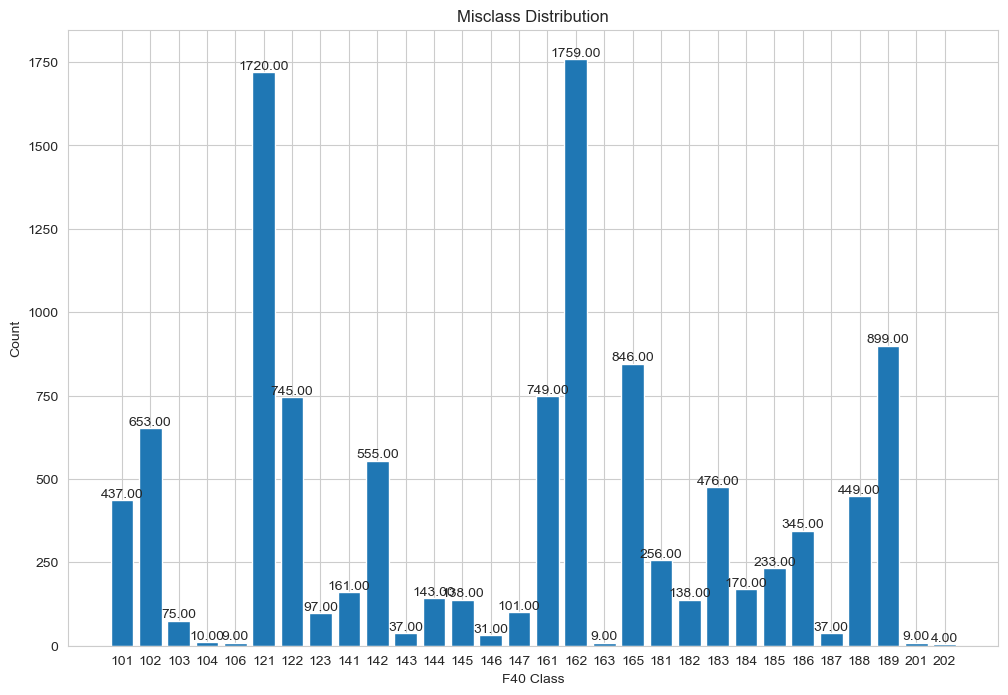

In [40]:
# Look at where misclasses are occurring 
## Aggregate which classes are being misclassed
misclass_grouped = misclasses.groupby('F40').count()['Predicted'].reset_index().rename(columns={'Predicted':'Count'})
misclass_grouped['F40'] = misclass_grouped['F40'].astype('str')
misclass_grouped['Percent'] = misclass_grouped['Count'] / misclass_grouped['Count'].sum() * 100

## Visualize the distribution
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(misclass_grouped['F40'],
              misclass_grouped[metric])
ax.set(title='Misclass Distribution',
       xlabel='F40 Class',
       ylabel=metric)
ax.bar_label(bars, fmt='%.2f')
plt.show()


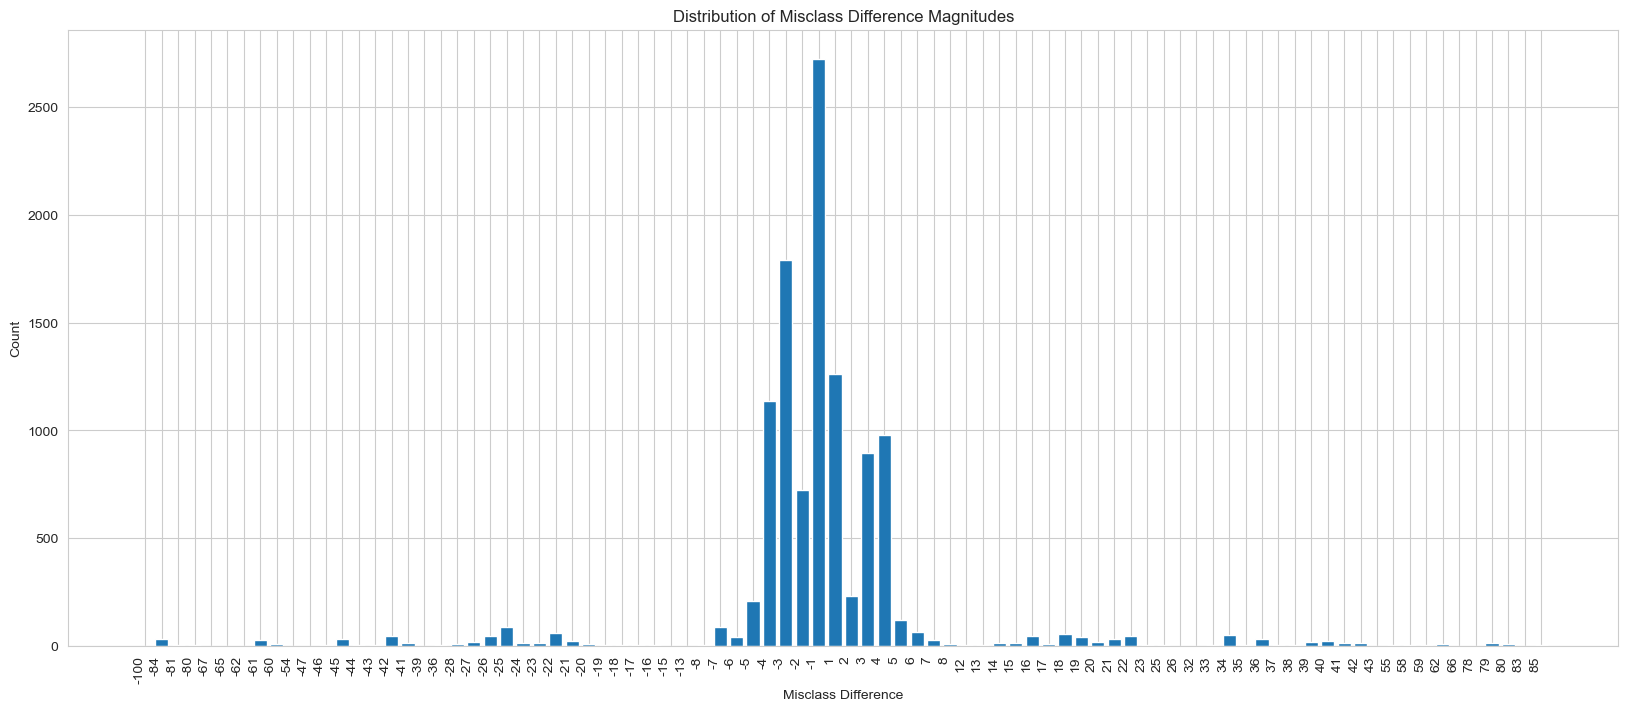

In [41]:
# Look at how far off the misclasses typically are
## Note that there are break between F40 "Classes" (e.g. GR vs. GS)

misclass_diff_grouped = misclasses.groupby('diff').count()['F40'].reset_index().rename(columns={'F40':'Count'})
misclass_diff_grouped['diff'] = misclass_diff_grouped['diff'].astype('str')

fig, ax = plt.subplots(figsize=(20,8))
bars = ax.bar(misclass_diff_grouped['diff'],
              misclass_diff_grouped['Count'])
ax.set(title='Distribution of Misclass Difference Magnitudes',
       xlabel="Misclass Difference",
       ylabel="Count")
plt.xticks(rotation='vertical', ha='right')
#ax.bar_label(bars, fmt="%.2f")
plt.show()